<a href="https://colab.research.google.com/github/EvelineC12/TopicosContemporaneos/blob/main/Primeiro_projeto_final_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Primeiro Projeto Final**

**Disciplina Tópicos Contemporâneos**

**Aluna:**

**Eveline Cavalcanti Feliciano Pontual** (ecfp@cesar.school)



**Objetivo do Projeto:** Fine-Tuning de uma CNN para Classificação

Um dataset de sua escolha deverá ser coletado e preparado para realizar o fine-tuning de uma CNN. O projeto será avaliado nos seguintes aspectos: Construção do Dataset, Data Augmentation, Uso de Modelos Pré-Treinados, Construção do Modelo Classificador, Congelamento de Camadas, Treinamento e Curvas de Desempenho

# **1. Baixar o dataset criado**

In [30]:
# Instalar a ferramenta gdown
!pip install gdown

# Baixar o arquivo usando gdown
!gdown "https://drive.google.com/uc?id=1noJAmWiPSPtAG-yE32bVqXXvHqtCAetC"

# Descompactar o arquivo
!unzip passaros.zip -d data/

Downloading...
From: https://drive.google.com/uc?id=1noJAmWiPSPtAG-yE32bVqXXvHqtCAetC
To: /content/passaros.zip
100% 10.2M/10.2M [00:00<00:00, 43.9MB/s]
Archive:  passaros.zip
   creating: data/passaros/
   creating: data/passaros/train/
   creating: data/passaros/train/beijaflor/
  inflating: data/passaros/train/beijaflor/10002.jpg  
  inflating: data/passaros/train/beijaflor/10016.png  
  inflating: data/passaros/train/beijaflor/10017.jpeg  
  inflating: data/passaros/train/beijaflor/10025.jpg  
  inflating: data/passaros/train/beijaflor/10026.jpeg  
  inflating: data/passaros/train/beijaflor/10027.jpg  
  inflating: data/passaros/train/beijaflor/10029.jpeg  
  inflating: data/passaros/train/beijaflor/10032.jpeg  
  inflating: data/passaros/train/beijaflor/10033.jpeg  
  inflating: data/passaros/train/beijaflor/10034.jpg  
  inflating: data/passaros/train/beijaflor/10035.jpg  
  inflating: data/passaros/train/beijaflor/10036.jpeg  
  inflating: data/passaros/train/beijaflor/10037.jpe

In [31]:
data_dir = "data/"

O dataset deste trabalho tem criação autoral. Imagens de pássaros da espécie beija-flor foram extraídas do Google Imagens através da ferramenta ImageAssistant Batch Image. Há aproximadamente 60 imagens para base de treino e 20 imagens para a base de validação.


# **2. Bibliotecas**

In [33]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# **3. Funções para treinar, testar e avaliar modelo de aprendizado profundo**

In [35]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# **4. Transformações de algumas imagens**

In [42]:
example_dir = os.path.join(data_dir, 'train')
#imagens da base de treino
example_set = datasets.ImageFolder(example_dir, transform=None)
example_images = [example_set[i][0] for i in random.sample(range(len(example_set)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de RandomResizedCrop -corte aleatório e redimensionamento
cropped_images = [transforms.RandomResizedCrop(224)(img) for img in example_images]
print("Após RandomResizedCrop")
show_images(cropped_images)

# Exemplo de RandomHorizontalFlip - Inverte aleatoriamente as imagens horizontalmente.
flipped_images = [transforms.RandomHorizontalFlip()(img) for img in cropped_images]
print("Após RandomHorizontalFlip")
show_images(flipped_images)

# Exemplo de RandomRotation - Aplica rotações aleatórias em uma imagem
rotated_images = [transforms.RandomRotation(15)(img) for img in example_images]
print("Após RandomRotation")
show_images(rotated_images)

# Exemplo de RandomAffine - Aplica uma transformação afim aleatória em uma imagem
affined_images = [transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img) for img in example_images]
print("Após RandomAffine")
show_images(affined_images)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

# **5. Datasets (treino e validação) com e sem aumentos (augmentations) de dados**

In [37]:
# Transformações com aumentos de dados (augmentations)
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),  # corte aleatório e redimensionamento
    transforms.RandomHorizontalFlip(),  # Inverter aleatoriamente as imagens horizontalmente
    transforms.RandomRotation(15),      # Aplica rotações aleatórias em uma imagem
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.05), # altera o brilho, contraste, saturação e matiz das imagens.
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10), #  aplica transformações geométricas em uma imagem, como rotação, translação e cisalhamento (shear)
    transforms.RandomVerticalFlip(),  # inverte aleatoriamente uma imagem na direção vertical (de cima para baixo)
    transforms.RandomInvert(0.5),  #inverte as cores de uma imagem aleatoriamente, aplicando uma inversão de tonalidade de cor
    transforms.ToTensor(),  #apesar de ser etapa comum de pré-processamento e não aumentar a diversidade dos dados, foi deixado aqui devido a sua necessidade para aplicações e comparações
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # #apesar de ser etapa comum de pré-processamento e não aumentar a diversidade dos dados, foi deixado aqui devido a sua necessidade para aplicações e comparações
])

# Transformações sem aumentos de dados (augmentations) - técnicas de pré-processamento
transform_no_aug = transforms.Compose([
    transforms.Resize(224),  # redimensiona imagem para uma altura (ou largura) específica
    transforms.CenterCrop(224), # corta (crop) uma imagem ao redor do centro, mantendo uma região quadrada de tamanho especificado
    transforms.ToTensor(), #converte uma imagem do tipo PIL ou NumPy ndarray para um tensor PyTorch - etapa comum de pré-processamento, não aumenta a diversidade dos dados
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #usado para normalizar as imagens
])

# Aplicações das Transformações nas bases e treino e validação
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True) #carrega os dados de treinamento em batches (lotes) durante o treinamento do modelo ( sem data augmentation)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)       #carrega os dados de treinamento em batches (lotes) durante o treinamento do modelo ( com data augmentation)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)                   #carregar os dados de validação em batches (lotes) durante o treinamento do modelo (sem data augmentation)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

# **6.Rede neural convolucional simples (CNN)**

# **6.1 Primeira Tentativa - sem dropout**

In [38]:
# primeira tentativa de função
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0) #camadas convolucionais são boas para extrair características hierárquicas de imagens
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 2 * 2, 128) # As camadas lineares (fc1, fc2, fc3) são responsáveis pela classificação da rede.
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0) #relu-função de ativação não linear, aplicada após as camadas convolucionais e lineares
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0) # F.max_pool2d após cada camada convolucional reduz a dimensionalidade espacial das imagens
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 64 * 2 * 2) # achata a saída das camadas convolucionais para que possa ser passada para as camadas lineares.
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Modelo
model = CNN(num_classes=4).to(device)

#Exemplo de entrada
x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)


torch.Size([1, 4])


**6.1.1 Aplicação do CNN -dataset sem aumento de dados**

In [40]:
model_no_aug = CNN(num_classes=4).to(device)

criterion_no_aug = nn.CrossEntropyLoss() # Função de perda para múltiplas classes
optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=0.001)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=20)

plot_history(history_no_aug)

NameError: name 'train_loader_no_aug' is not defined

**6.1.2 Aplicação do CNN no dataset com aumentos de dados**

In [43]:
model_aug = CNN(num_classes=4).to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=20)

plot_history(history_aug)

NameError: name 'train_loader_aug' is not defined

# **6.2 Segunda Tentativa - Com Dropout**

In [44]:
class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.dropout1 = nn.Dropout(0.4)  # Adicionando dropout
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Aplicando dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicialização do modelo
model2 = CNN2(num_classes=4).to(device)

# Exemplo de entrada
x = torch.randn(1, 3, 224, 224).to(device)
print(model2(x).shape)

torch.Size([1, 4])


**6.2.1 Aplicação do CNN -dataset sem aumento de dados**

In [45]:
model_no_aug2 = CNN2(num_classes=4).to(device)

criterion_no_aug2 = nn.CrossEntropyLoss() # Função de perda para múltiplas classes
optimizer_no_aug2 = optim.Adam(model_no_aug2.parameters(), lr=0.001)

history_no_aug2 = train_model(model_no_aug2, train_loader_no_aug, val_loader, criterion_no_aug2, optimizer_no_aug2, device, num_epochs=30)

plot_history(history_no_aug2)

NameError: name 'train_loader_no_aug' is not defined

**6.2.2 Aplicação do CNN -com dropout e dataset com aumento de dados**

In [47]:
model_aug2 = CNN2(num_classes=4).to(device)

criterion_aug2 = nn.CrossEntropyLoss()
optimizer_aug2 = optim.Adam(model_aug2.parameters(), lr=0.001)

history_aug2 = train_model(model_aug2, train_loader_aug, val_loader, criterion_aug2, optimizer_aug2, device, num_epochs=30)

plot_history(history_aug2)

NameError: name 'train_loader_aug' is not defined

# **7. Aplicação de Modelos Pré-Treinados**


**7.1 Definição das transformações com e sem data augmentation e datasets (treino e validação)**

In [48]:
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

**7.2 Definição da função de treinamento e avaliação**

In [49]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

**7.3. Carregamento dos Modelos com Pesos Pré-Treinados**

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar ResNet50 com pesos pré-treinados
resnet_model_v1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet_model_v2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Carregar VGG16 com pesos pré-treinados
vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modificar a camada final para o número de classes do seu dataset
num_classes = len(train_set_no_aug.classes)  # ou train_set_aug.classes, depende do seu dataset
print(num_classes) #o correto é 4, pois são 4 tipos de frutas

resnet_model_v1.fc = nn.Linear(resnet_model_v1.fc.in_features, num_classes)
resnet_model_v2.fc = nn.Linear(resnet_model_v2.fc.in_features, num_classes)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# Transferir os modelos para o dispositivo (GPU ou CPU)
resnet_model_v1 = resnet_model_v1.to(device)
resnet_model_v2 = resnet_model_v2.to(device)
vgg_model = vgg_model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.7MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.8MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 134MB/s]


NameError: name 'train_set_no_aug' is not defined

In [51]:
print(resnet_model_v1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
print(resnet_model_v2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**7.4 Definição do otimizador e critério de perda**

In [54]:
criterion = nn.CrossEntropyLoss()

optimizer_resnet_v1 = optim.Adam(resnet_model_v1.parameters(), lr=0.001)
optimizer_resnet_v2 = optim.Adam(resnet_model_v2.parameters(), lr=0.001)
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)

# **7.5 Treinamento e Avaliação do Modelo Pré-Treinado**

# **7.5.1 ResNet50 (versão 1)**

**7.5.1.1 Aplicado na Base de Treino sem aumento**

In [55]:
import matplotlib.pyplot as plt

# Listas para armazenar as métricas de cada época
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1) #é aplicado na base de treino sem aumento
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_no_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_no_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

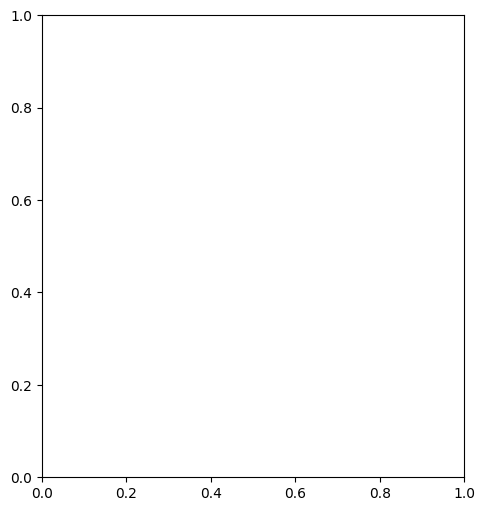

In [56]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**7.5.1.2 Aplicado na Base de Treino com aumento de dados**

In [57]:
# Listas para armazenar as métricas de cada época
train_losses2 = []
train_accuracies2= []
val_losses2 = []
val_accuracies2 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1) #é aplicado na base de treino sem aumento
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses2.append(train_loss)
    train_accuracies2.append(train_acc)
    val_losses2.append(val_loss)
    val_accuracies2.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

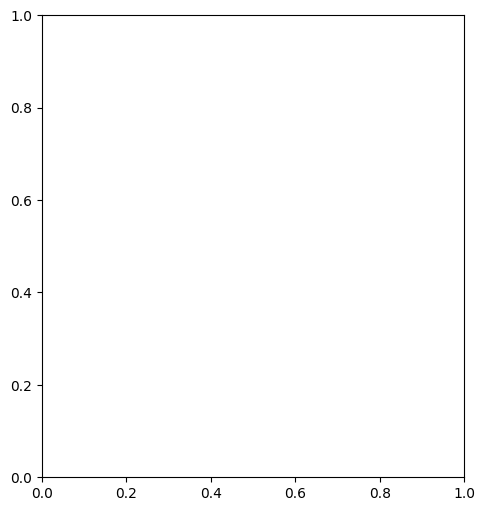

In [58]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses2, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies2, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies2, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **7.5.2 ResNet50 (versão 2)**

**7.5.2.1 Aplicado na Base de Treino sem aumento de dados**

In [59]:
# Listas para armazenar as métricas de cada época
train_losses3 = []
train_accuracies3 = []
val_losses3 = []
val_accuracies3 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 2)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v2, train_loader_no_aug, criterion, optimizer_resnet_v2, device)
    val_loss, val_acc = evaluate(resnet_model_v2, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses3.append(train_loss)
    train_accuracies3.append(train_acc)
    val_losses3.append(val_loss)
    val_accuracies3.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_no_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

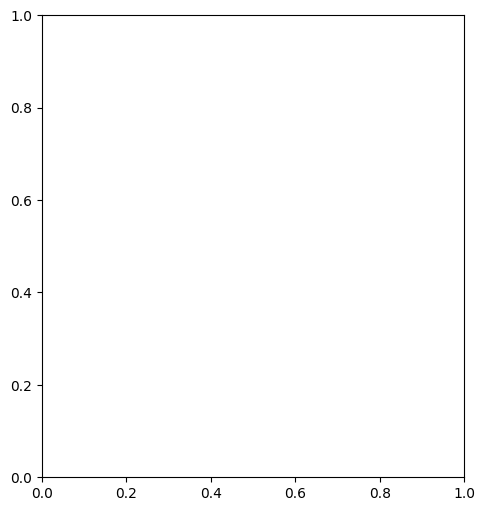

In [60]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses3, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses3, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies3, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies3, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**7.5.2.1 Aplicado na Base de Treino com aumento de dados**

In [61]:

# Listas para armazenar as métricas de cada época
train_losses4 = []
train_accuracies4 = []
val_losses4 = []
val_accuracies4 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 2)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v2, train_loader_aug, criterion, optimizer_resnet_v2, device)
    val_loss, val_acc = evaluate(resnet_model_v2, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses4.append(train_loss)
    train_accuracies4.append(train_acc)
    val_losses4.append(val_loss)
    val_accuracies4.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

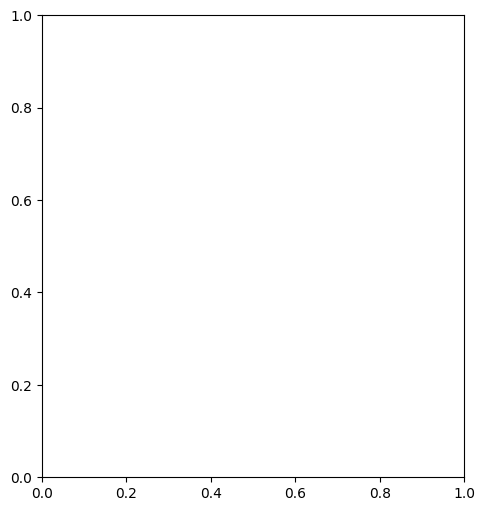

In [62]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses4, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses4, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies4, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies4, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **7.5.3 VGG**

**7.5.3.1 Aplicado na Base de Treino sem aumento de dados**

In [63]:

# Listas para armazenar as métricas de cada época
train_losses5 = []
train_accuracies5 = []
val_losses5 = []
val_accuracies5 = []

num_epochs = 20

# Treinamento e Avaliação do VGG
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(vgg_model, train_loader_no_aug, criterion, optimizer_vgg, device)
    val_loss, val_acc = evaluate(vgg_model, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses5.append(train_loss)
    train_accuracies5.append(train_acc)
    val_losses5.append(val_loss)
    val_accuracies5.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_no_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

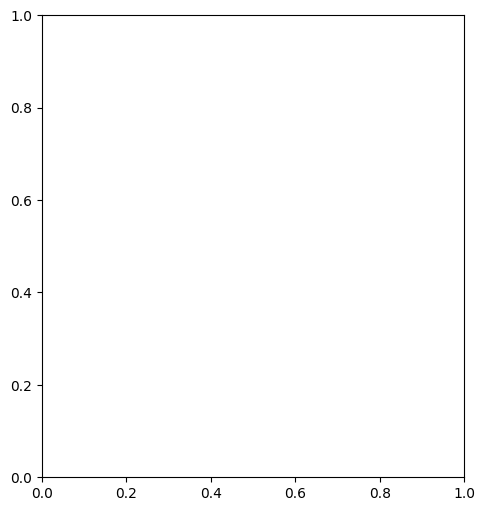

In [64]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses5, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses5, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies5, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies5, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**7.5.3.2 Aplicado na Base de Treino com aumento de dados**

In [65]:
# Listas para armazenar as métricas de cada época
train_losses6 = []
train_accuracies6 = []
val_losses6 = []
val_accuracies6 = []

num_epochs = 20

# Treinamento e Avaliação do VGG
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(vgg_model, train_loader_aug, criterion, optimizer_vgg, device)
    val_loss, val_acc = evaluate(vgg_model, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses6.append(train_loss)
    train_accuracies6.append(train_acc)
    val_losses6.append(val_loss)
    val_accuracies6.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

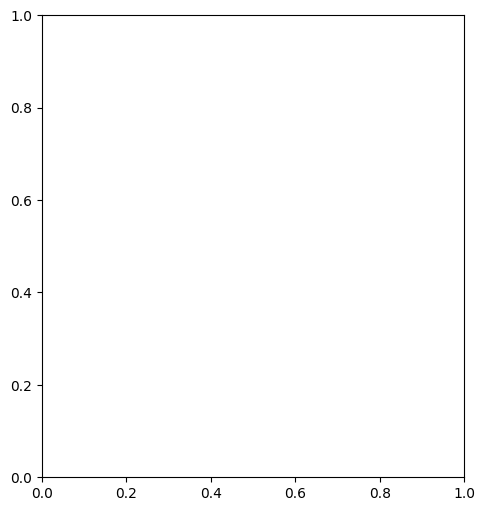

In [66]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses6, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses6, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies6, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies6, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **8. Congelamento das Camadas**

In [67]:
# Carregar ResNet50 com pesos pré-treinados
resnet_model_v1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet_model_v1.parameters():
    param.requires_grad = False

# Modificar a camada final para o número de classes do dataset
num_classes = len(train_set_aug.classes)

resnet_model_v1.fc = nn.Linear(resnet_model_v1.fc.in_features, num_classes)

# Transferir os modelos para o dispositivo (GPU ou CPU)
resnet_model_v1 = resnet_model_v1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_resnet_v1 = optim.Adam(resnet_model_v1.parameters(), lr=0.001)

NameError: name 'train_set_aug' is not defined

In [68]:
# Listas para armazenar as métricas de cada época
train_losses0 = []
train_accuracies0 = []
val_losses0 = []
val_accuracies0 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses0.append(train_loss)
    train_accuracies0.append(train_acc)
    val_losses0.append(val_loss)
    val_accuracies0.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20


NameError: name 'train_loader_aug' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

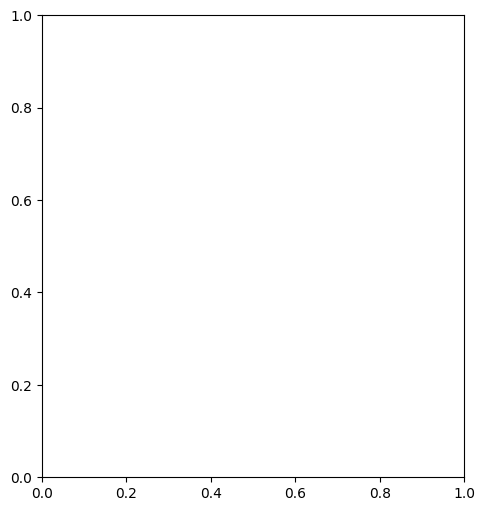

In [69]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses0, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses0, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies0, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies0, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **9. Conclusões**

A coleta de dados, mesmo que simples, é de grande importância para o desenvolvimento de modelos de CNN de classificação, independente se pré-treinados ou não. É importante ter atenção na representatividade desses dados, tanto no âmbito da qualidade como quantidade.

